### `Import the main Libraries`

In [1]:
## Major
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import re
import string
from tqdm import tqdm
import joblib

## plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## nltk -- for text processing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

## sklearn -- for processing and models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## SMOTE for imblanced dataset
from imblearn.over_sampling import SMOTE

## Optimization Algorithm using Jaya Optimizer
from mealpy.swarm_based.JA import BaseJA, OriginalJA, LevyJA

## Filter Warnings
import warnings
warnings.filterwarnings('ignore')

### `Load the Dataset & Look at the big picture`

In [2]:
## Readind using pandas
df = pd.read_csv('testdata.manual.2009.06.14.csv', 
                 encoding='ISO-8859-1', names=['target', 'id', 'date', 'flags', 'user', 'text'])
df.head()

,target,id,date,flags,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)


----

### `Exploratory Data Analyis`

In [3]:
print('The Shape of the Dataset is: ', df.shape)

The Shape of the Dataset is:  (498, 6)


In [4]:
## Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  498 non-null    int64 
 1   id      498 non-null    int64 
 2   date    498 non-null    object
 3   flags   498 non-null    object
 4   user    498 non-null    object
 5   text    498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [5]:
## DataTypes
df.dtypes

target     int64
id         int64
date      object
flags     object
user      object
text      object
dtype: object

In [6]:
## check null values
df.isna().sum(axis=0)  ## ok

target    0
id        0
date      0
flags     0
user      0
text      0
dtype: int64

In [7]:
## Check the Traget values
df['target'].unique()   

array([4, 0, 2], dtype=int64)

In [8]:
## Distr. of target
df['target'].value_counts()  ## imblanced dataset -- 4:Positive, 0: Negative, 2: Neutral

4    182
0    177
2    139
Name: target, dtype: int64

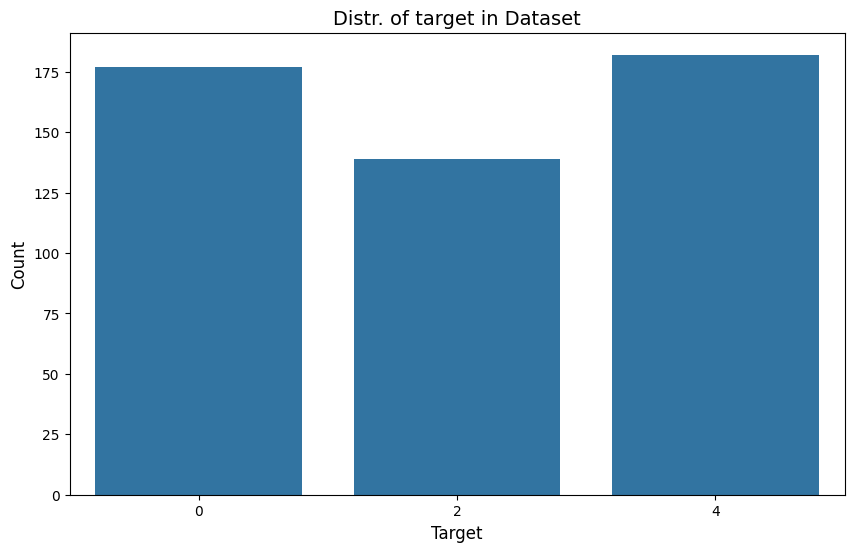

In [9]:
## countplot of target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='k')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [10]:
## take a deep copy from the DF
dataset = df[['target', 'text']]
dataset

,target,text
0,4,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7
494,0,"On that note, I hate Word. I hate Pages. I hate LaTeX. There, I said it. I hate LaTeX. All you TEXN3RDS can come kill me now."
495,4,Ahhh... back in a *real* text editing environment. I &lt;3 LaTeX.
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far away. #flockofseagullsweregeopoliticallycorrect"


----

### `Text Cleaning & Visualization`

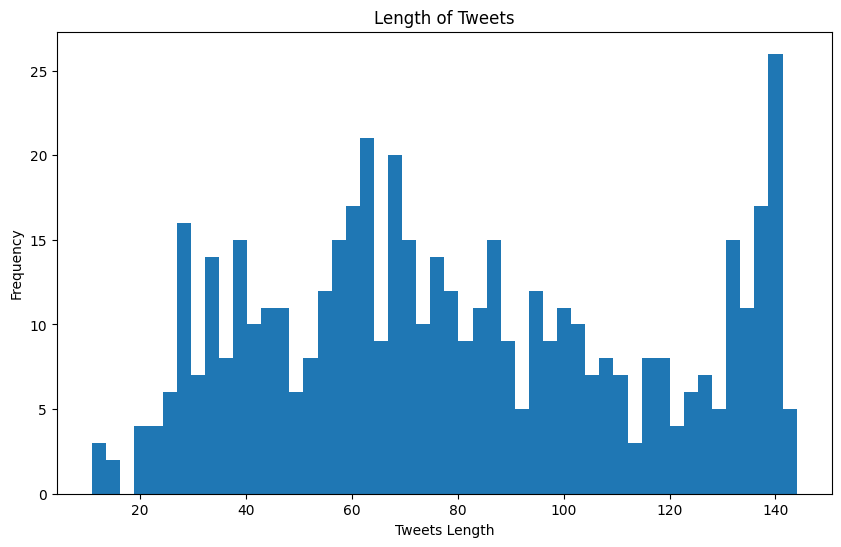

In [11]:
## Check Length of Tweets
length_tweets = dataset['text'].str.len()
## Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_tweets, bins=50)
plt.title('Length of Tweets')
plt.xlabel('Tweets Length')
plt.ylabel('Frequency')
plt.show()

In [12]:
## Hashtags
def hashtag_extract(x):
    hashtags = []
    ## Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

## Extracting hashtags from non racist tweets
hash_neg = hashtag_extract(dataset['text'][dataset['target'] == 0])  ## Negative
hash_pos = hashtag_extract(dataset['text'][dataset['target'] == 4])  ## Positive
hash_neu = hashtag_extract(dataset['text'][dataset['target'] == 2])  ## Neutral

## Unnesting list
hash_neg = sum(hash_neg, [])
hash_pos = sum(hash_pos, [])
hash_neu = sum(hash_neu, [])

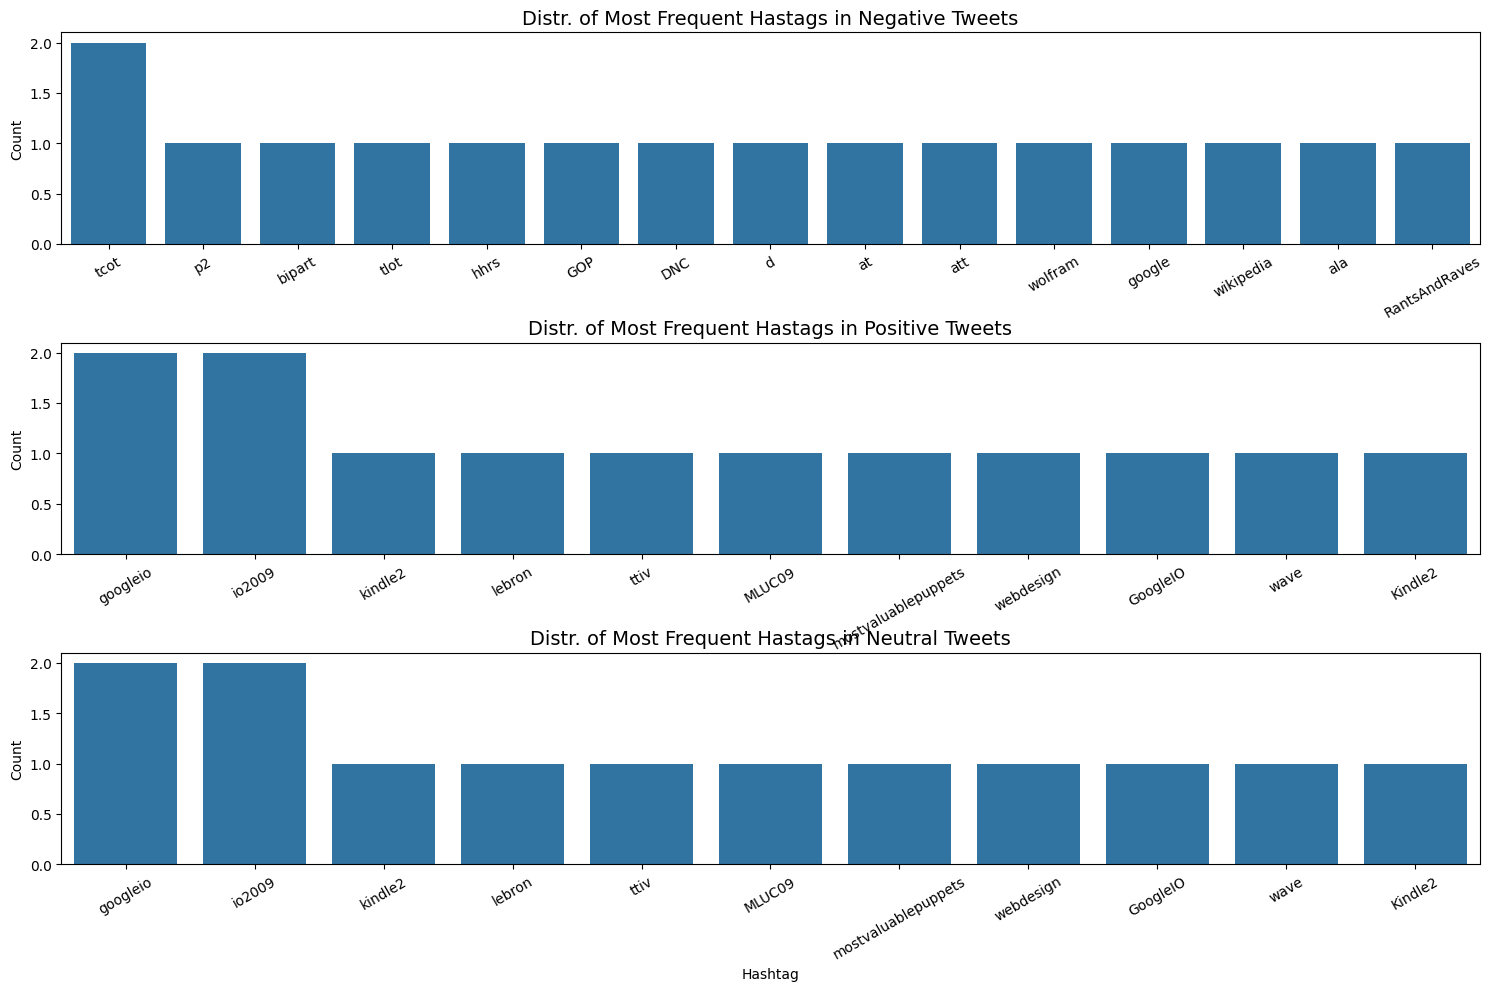

In [13]:
## Hashtags in Tweets
a_neg = nltk.FreqDist(hash_neg)
a_pos = nltk.FreqDist(hash_pos)
a_neu = nltk.FreqDist(hash_neu)

## Negative Tweets
df_neg = pd.DataFrame({'Hashtag': list(a_neg.keys()),
                  'Count': list(a_neg.values())})

## Positive Tweets
df_pos = pd.DataFrame({'Hashtag': list(a_pos.keys()),
                  'Count': list(a_pos.values())})

## Neutral Tweets
df_neu = pd.DataFrame({'Hashtag': list(a_neu.keys()),
                  'Count': list(a_neu.values())})

# selecting top 15 most frequent hashtags     
df_neg = df_neg.nlargest(columns='Count', n=15) 
df_pos = df_pos.nlargest(columns='Count', n=15) 
df_neu = df_pos.nlargest(columns='Count', n=15)

## Plotting
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
fig.tight_layout(pad=5)
plt.sca(ax[0])
sns.barplot(data=df_neg, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Negative Tweets', fontsize=14, c='k')
plt.xlabel('')
##
plt.sca(ax[1])
sns.barplot(data=df_pos, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Positive Tweets', fontsize=14, c='k')
plt.xlabel('')
##
plt.sca(ax[2])
sns.barplot(data=df_neu, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Neutral Tweets', fontsize=14, c='k')
plt.show()

---

In [14]:
## Remove unwanted text patterns from the tweets
def remove_pattern(input_txt: str, pattern: str):
    ''' This Function takes the input and pattern you want to remove

    Args:
    *****
        (input_text: str) --> The text you want to apply the function to it.
        (pattern: str) --> The pattern you want to remove from the text.
    '''
  
    input_txt = re.sub(pattern, '', input_txt)
    return input_txt

------

####  `Remove tags`

In [15]:
## Removing @user in tweets, and apply the function
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'@[\w]*')
dataset.head()

,target,text
0,4,"I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


----

#### `Rmove Hyperlinks`

In [16]:
## An exmaple before removing links
dataset['text'].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7'

In [17]:
## Define a regular expression pattern to match URLs
## Apply the above function
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'https?://\S+|www\.\S+')
dataset.head()

,target,text
0,4,"I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


In [18]:
## The same exmaple after removing links
dataset['text'].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] '

----

#### `Remove Repeated Characters`
* It is very challenging, There is no unique solution for this problem.
* We can remove repeated chars from words but it will affect other correct words like (happy be hapy)
* So, We can solve it bydefining a max repeat, Let's make it 2
* Note: It may produces some a few errors (But there is no better solution for that)
* These errors may be solved in stemmer or lemmatizer later

In [19]:
## An exmaple before removing repeated chars
dataset['text'].iloc[0]

' I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

In [20]:
## A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    ## Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    ## Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

## Apply the above function
dataset['text'] = dataset['text'].apply(remove_excessive_repeated_characters)
dataset.head()

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


In [21]:
## The same exmaple after removing repeated chars
dataset['text'].iloc[0]

' I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

----

#### `Emoticons Mapping`

In [22]:
## Check on sample before mapping emoticons
dataset['text'].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! :)'

In [23]:
## Convert Emojis to Text : example 😀 to Happy , 😢 Sad
## This Dataset doesn't contains emojis, but it contains emotioncons like that :D, :)
## So, We can't demojize, but we will map the moticons to its meaning.

emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}


## Function to replace emoticons with their meanings
def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead 
    '''
    for emoticon, meaning in emoticon_meanings.items():
        text = text.replace(emoticon, meaning)
    return text

## Apply the function on our dataset
dataset['text'] = dataset['text'].apply(convert_emoticons)
dataset.head()

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! Happy
4,4,Fair enough. But i have the Kindle2 and I think it's perfect Happy


In [24]:
## The same exmaple after mapping emoticons
dataset['text'].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! Happy'

-----

#### `Remove Punctuations, Numbers, and Special Characters`

In [25]:
## Removing Punctuations, Numbers, and Special Characters
dataset['text'] = dataset['text'].str.replace('[^a-zA-Z#]', ' ')
dataset.head()

,target,text
0,4,I love my Kindle Not that the DX is cool but the is fantastic in its own right
1,4,Reading my kindle Love it Lee childs is good read
2,4,Ok first assesment of the #kindle it fucking rocks
3,4,You ll love your Kindle I ve had mine for a few months and never looked back The new big one is huge No need for remorse Happy
4,4,Fair enough But i have the Kindle and I think it s perfect Happy


-----

#### `Removing Short Words`

In [26]:
## Removing Short Words
dataset['text'] = dataset['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back huge need remorse Happy
4,4,Fair enough have Kindle think perfect Happy


-------

#### `Rmove Numbers from words`

In [27]:
## Call the above function (remove_pattern), We want to remove the numbers from words 
## We don't remove all numbers on the dataset, The pattern only removes the numbers within the words
dataset['text'] = np.vectorize(remove_pattern)(input_txt=dataset['text'], pattern='(?<=\w)\d+|\d+(?=\w)')
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back huge need remorse Happy
4,4,Fair enough have Kindle think perfect Happy


---------

#### `Remove Special Characters`

In [28]:
## An exmaple before removing special chars
dataset['text'].iloc[2]

'first assesment #kindle fucking rocks'

In [29]:
## Define a regular expression pattern to match special characters
## Apply the function to the dataset
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]')
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment kindle fucking rocks
3,4,love your Kindle mine months never looked back huge need remorse Happy
4,4,Fair enough have Kindle think perfect Happy


In [30]:
## The same exmaple after removing special chars
dataset['text'].iloc[2]

'first assesment kindle fucking rocks'

-------

#### `Remove redundant words and extra spaces`

``` python
    ## Download it if it is required
    nltk.download('stopwords')
```

In [31]:
## An exmaple before solving that
dataset['text'].iloc[3]

'love your Kindle mine months never looked back huge need remorse Happy'

In [32]:
## A Function to remove redundant words like (I've, You'll)
## Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    ## Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    ## Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    ## Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    ## Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


## Apply the above function
dataset['text'] = dataset['text'].apply(remove_redundant_words_extra_spaces)

In [33]:
## The same exmaple after solving that 
dataset['text'].iloc[3]

'love Kindle mine months never looked back huge need remorse Happy'

In [34]:
## Download the dataset here at this step before Stemming or Lemmatizing
dataset.to_excel('dataset_1_cleaned.xlsx', index=False)

------

#### `Tokenizing, Stemming & Lemmatization`
`It is optional, But We can use it to limit the variations in the dataset`

In [35]:
## Tokenization
tokenized_tweet = dataset['text'].apply(lambda x: x.split()) 
tokenized_tweet.head()

0                                           [love, Kindle, cool, fantastic, right]
1                                      [Reading, kindle, Love, childs, good, read]
2                                       [first, assesment, kindle, fucking, rocks]
3    [love, Kindle, mine, months, never, looked, back, huge, need, remorse, Happy]
4                                    [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [36]:
# ## Stemming
# stemmer = PorterStemmer()

# tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
# tokenized_tweet.head()

In [37]:
## Lemmatization
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x]) # lemmatizer
tokenized_tweet.head()

0                                          [love, Kindle, cool, fantastic, right]
1                                      [Reading, kindle, Love, child, good, read]
2                                       [first, assesment, kindle, fucking, rock]
3    [love, Kindle, mine, month, never, looked, back, huge, need, remorse, Happy]
4                                   [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [38]:
## Join words again and append it to (dataset DF)
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
dataset['text'] = tokenized_tweet
dataset.head()

,target,text
0,4,love Kindle cool fantastic right
1,4,Reading kindle Love child good read
2,4,first assesment kindle fucking rock
3,4,love Kindle mine month never looked back huge need remorse Happy
4,4,Fair enough Kindle think perfect Happy


In [39]:
## Download the dataset after tokenizing, stemming, lemmatizing
dataset.to_excel('dataset_1_after_tokenized.xlsx', index=False)

----

### `Some Vizualization`

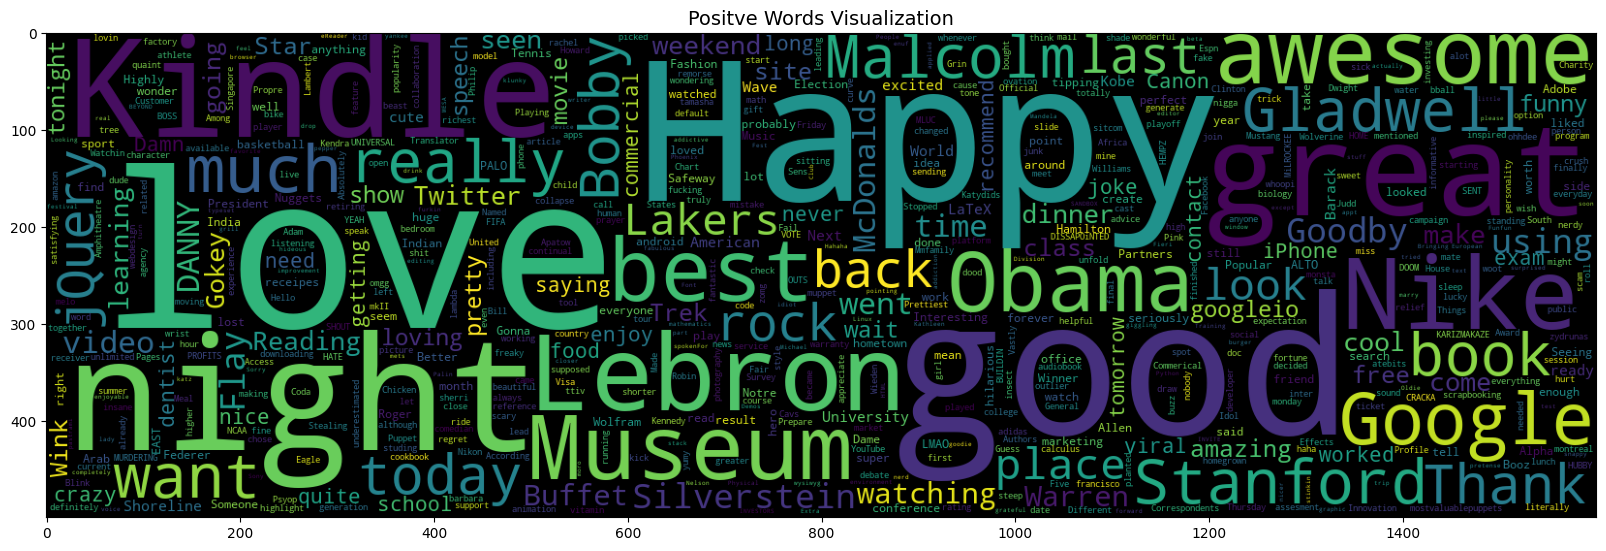

In [40]:
## For Positive Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==4]['text'].astype(str)))
plt.title('Positve Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

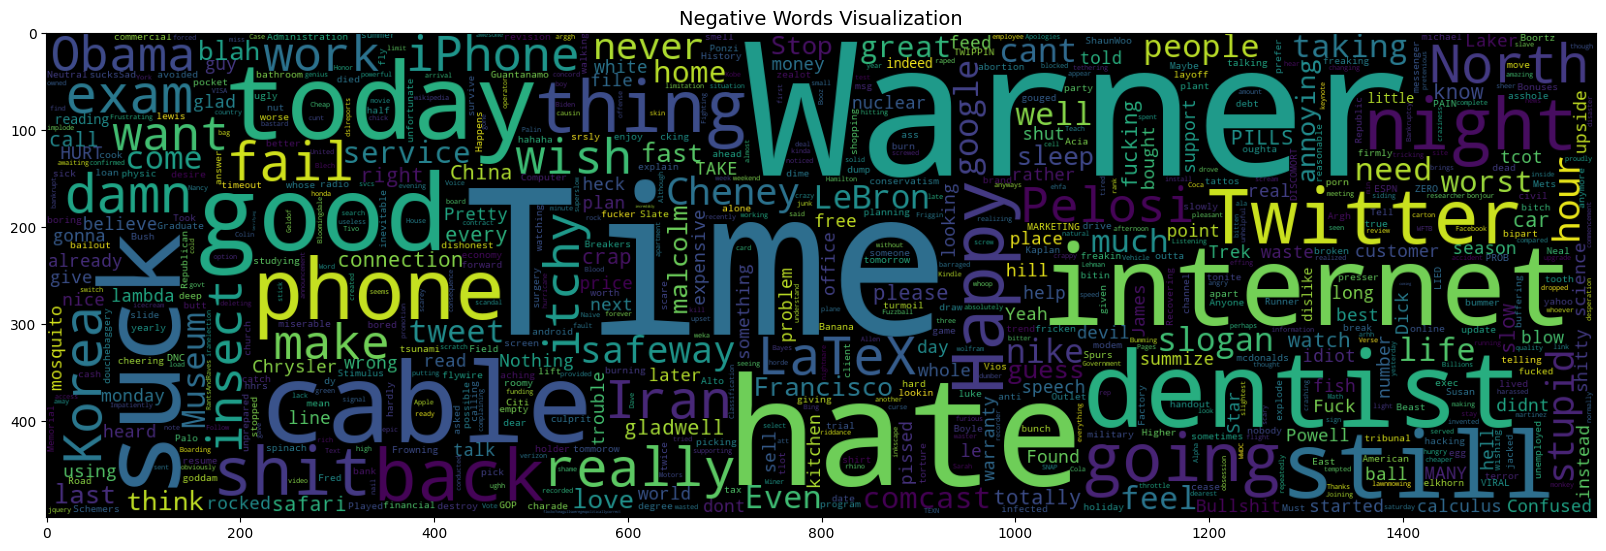

In [41]:
## For Negative Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==0]['text'].astype(str)))
plt.title('Negative Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

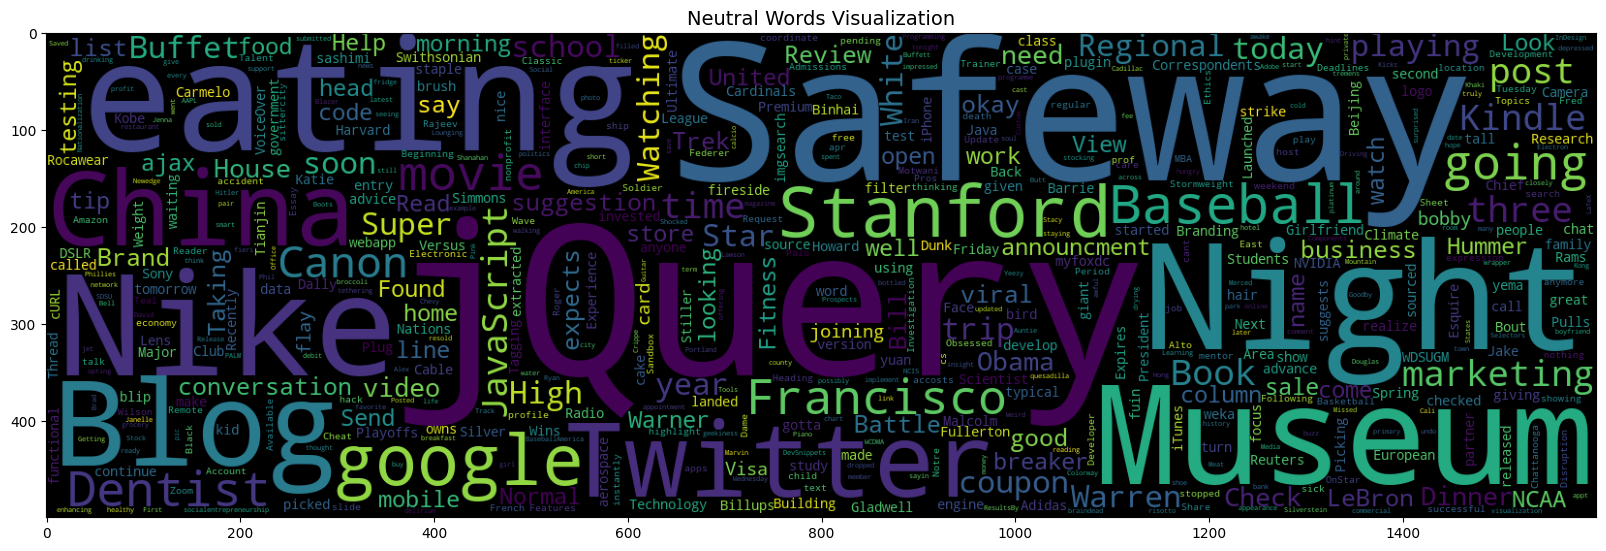

In [42]:
## For Neutral Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==2]['text'].astype(str)))
plt.title('Neutral Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

### `Text Preprocessing`
`I will try differnet techiques (BOW, TF-IDF)`

In [43]:
## Previously, I made max_features=1000, These are just parameters
## To be 1000 means to take only the features that repeated much more
## Note: It is max_features not features (may be features numbers in the dataset is less than that)

####  `1. BOW`

In [44]:
## Extracting Features from Cleaned Tweets using BOW 
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_bow = bow_vectorizer.fit_transform(dataset['text'])
X_bow = X_bow.toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

####  `2. TF-IDF`

In [45]:
## Extracting Features from Cleaned Tweets using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(dataset['text'])
X_tfidf = X_tfidf.toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

------

### `Split the Dataset`

In [46]:
## mapping --> Some Algoritms can't handle non sequential encoding
dict_map = {0: 0, 4: 1, 2: 2}    ## 0: Negative (still 0) || 4: Positive > 1 || 2: Neutral (still 2)
dict_rev_map = {v:k for k, v in dict_map.items()}

## Apply that to the dataset
dataset['target']= dataset['target'].map(dict_map)
dataset['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [47]:
## Function to be easy in training the model
def before_models(method='BOW'):
    if method == 'bow' or method == 'BOW':
        X = X_bow
    elif method == 'tfidf' or method == 'TFIDF':
        X = X_tfidf
    else:
        print('Enter a method from (bow, tfidf)')
        
    y = dataset['target']
    
    ## Using SMOTE to solve imblanced dataset
    over = SMOTE()
    X_new, y_new = over.fit_resample(X, y)

    ## Split Datsets to train and test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, 
                                                        shuffle=True, stratify=y_new, 
                                                        test_size=0.2, random_state=15)
    
    return X_train, X_test, y_train, y_test

-----

## <center>`Building Models` </center>


* I will follow the following steps:
* `Secondly, With Jaya (In This Notebook):`
    * 1. `SVM` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `with Jaya`
    * 2. `KNN` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `with Jaya`
    * 3. `Logistic Regression` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `with Jaya`
    * 4. `Random Forest` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `with Jaya`
    * 5. `Decision Trees` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `with Jaya`
    * 6. `Naive Bayes` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `with Jaya`
    * 7. `XGBOOST` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `with Jaya`

------------

### `Jaya-SVM`

In [56]:
def svc_with_jaya(method: str):
    ''' This Function is to train SVM with Jaya optimizer. 
    Args:
    *****
        (method: str) --> The method one of (BOW, TFIDF, Word2Vec, BERT)
    '''
    
    ## Call the function --> split the dataset
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## LABEL ENCODER (for svc kernels)
    KERNEL_ENCODER = LabelEncoder()
    KERNEL_ENCODER.fit(['linear', 'poly', 'rbf', 'sigmoid'])

    def fitness_function(solution):
        ''' This is fitness function which will be passed to Jaya Optimizer & return accuracy score
        '''
        # if kernel belongs to 0 - 0.99 ==> 0       ==> linear
        #                      1 - 1.99 ==> 1       ==> poly
        #                      2 - 2.99 ==> 2       ==> rbf
        #                      3 - 3.99 ==> 3       ==> sigmoid

        ## Choosing the kernels and Hyperparameter(C)
        kernel_encoded = int(solution[0])  ## kernel
        c = solution[1]                    ## C

        ## Just instead of text, but index
        kernel_decoded = KERNEL_ENCODER.inverse_transform([kernel_encoded])[0]  

        ## SVC Model
        svc = SVC(C=c, random_state=42, kernel=kernel_decoded)
        ## Fit the model
        svc.fit(X_train, y_train)

        ## Make the predictions
        y_pred = svc.predict(X_test)

        ## Measure the performance (accuracy)
        return accuracy_score(y_test, y_pred)
    
    
    ## Use Jaya Optimizer, Prepare Bounds
    problem = {
        "fit_func": fitness_function,
        "lb": [0, 0.01],
        "ub": [3.99, 700],
        "minmax": "max",
                }

    ## Prepare bounds and the objective function
    model = LevyJA(epoch=15, pop_size=150)
    model.solve(problem)
    print(f"Best Kernel: {KERNEL_ENCODER.inverse_transform([int(model.solution[0][0])])[0]}, \
            Best C: {model.solution[0][1]}")
    print('----'*15)
    
    ## Get the best params to train SVC on it
    best_c = model.solution[0][1]
    best_kernel = KERNEL_ENCODER.inverse_transform([int(model.solution[0][0])])[0]

    ## Finally SVC on tuned params
    svc = SVC(C=best_c, kernel=best_kernel)
    svc.fit(X_train, y_train)

    ## Accuracy
    y_pred_train = svc.predict(X_train)
    y_pred_test = svc.predict(X_test)

    acc_train = round(100*accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(100*accuracy_score(y_test, y_pred_test), 4)

    print(f'Accuracy Score for Training Dataset using {method} using SVM: \t {acc_train} %')
    print(f'Accuracy Score for Tesing Dataset using {method} using SVM: \t {acc_test} %')
    print('----'*15)

    ## I will return the Model itself (In case we want to download it or use it later for Deployment) with accuracies.
    return svc, acc_train, acc_test

`1. Using BOW`

In [57]:
## SVC using BOW Features
svc_bow, acc_train_svm_bow, acc_test_svm_bow = svc_with_jaya(method='BOW')

2023/09/02 06:38:47 PM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/02 06:38:59 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.7181818181818181, Global best: 0.7181818181818181, Runtime: 5.82053 seconds
2023/09/02 06:39:06 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.7272727272727273, Global best: 0.7272727272727273, Runtime: 7.07154 seconds
2023/09/02 06:39:14 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.7272727272727273, Global best: 0.7272727272727273, Runtime: 7.72342 seconds
2023/09/02 06:39:20 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.7272727272727273, Global best: 0.7272727272727273, Runtime: 6.06818 seconds
2023/09/02 06:39:26 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.7272727272727273, Global best: 0.7272727272727273, Runtime: 6.49859 seconds
2023/09/02 06:39:3

Best Kernel: sigmoid,             Best C: 1.402348873826896
------------------------------------------------------------
Accuracy Score for Training Dataset using BOW using SVM: 	 82.5688 %
Accuracy Score for Tesing Dataset using BOW using SVM: 	 75.4545 %
------------------------------------------------------------


`2. Using TFIDF`

In [58]:
## SVC using TFIDF Features
svc_tfidf, acc_train_svm_tfidf, acc_test_svm_tfidf = svc_with_jaya(method='TFIDF')

2023/09/02 06:40:28 PM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/02 06:40:43 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.7545454545454545, Global best: 0.7545454545454545, Runtime: 7.05217 seconds
2023/09/02 06:40:50 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.7636363636363637, Global best: 0.7636363636363637, Runtime: 7.09463 seconds
2023/09/02 06:40:57 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.7636363636363637, Global best: 0.7636363636363637, Runtime: 7.23662 seconds
2023/09/02 06:41:05 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.7636363636363637, Global best: 0.7636363636363637, Runtime: 7.58543 seconds
2023/09/02 06:41:12 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.7636363636363637, Global best: 0.7636363636363637, Runtime: 7.64405 seconds
2023/09/02 06:41:1

Best Kernel: sigmoid,             Best C: 1.5087376311026972
------------------------------------------------------------
Accuracy Score for Training Dataset using TFIDF using SVM: 	 88.7615 %
Accuracy Score for Tesing Dataset using TFIDF using SVM: 	 76.3636 %
------------------------------------------------------------


* `Combine all for Jaya-SVM` 

In [61]:
## Combine all results of SVM with Jaya in one DataFrame
acc_train_svm = [acc_train_svm_bow, acc_train_svm_tfidf]
acc_test_svm = [acc_test_svm_bow, acc_test_svm_tfidf]


## Create a DataFrame for SVM accuracies
data_svm = {
        'Method': ['Jaya-SVM BOW', 'Jaya-SVM TF-IDF'],
        'Train Accuracy': acc_train_svm,
        'Test Accuracy': acc_test_svm
            }

svm_accuracy_df = pd.DataFrame(data_svm)
svm_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,Jaya-SVM BOW,82.5688,75.4545
1,Jaya-SVM TF-IDF,88.7615,76.3636
2,Jaya-SVM Word2Vec,87.3853,77.2727
3,Jaya-SVM BERT,97.2477,77.2727


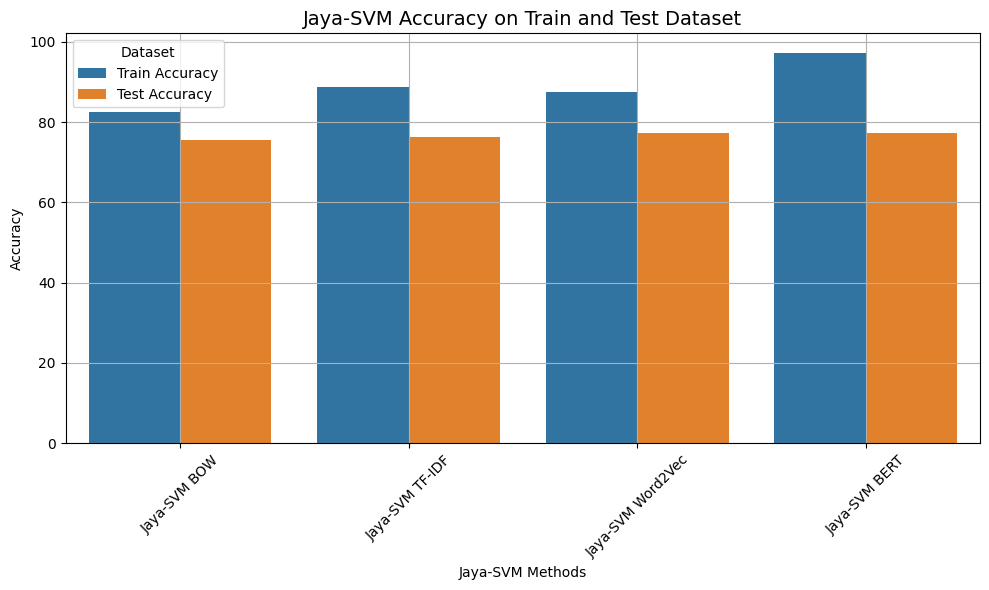

In [62]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
svm_accuracy_df_pivot = svm_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=svm_accuracy_df_pivot)
plt.xlabel('Jaya-SVM Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('Jaya-SVM Accuracy on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

-----------

### `Jaya-KNN`

In [63]:
def knn_with_jaya(method: str):
    ''' This Function is to train KNN with Jaya optimizer. 
    Args:
    *****
        (method: str) --> The method one of (BOW, TFIDF, Word2Vec, BERT)
    '''
    
    ## Call the function --> split the dataset
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    def fitness_function(solution):
        ''' This is fitness function which will be passed to Jaya Optimizer & return accuracy score
        '''
        ## Choosing the params of KNN
        k = int(solution[0])
        p = int(solution[1])                  

        ## KNN Model
        knn = KNeighborsClassifier(n_neighbors=k, p=p)
        ## Fit the model
        knn.fit(X_train, y_train)

        ## Make the predictions
        y_pred = knn.predict(X_test)

        ## Measure the performance (accuracy)
        return accuracy_score(y_test, y_pred)
    
    ## Use Jaya Optimizer, Prepare Bounds (KNN Bounds for k & p)
    problem = {
        "fit_func": fitness_function,
        "lb": [2, 1],
        "ub": [15, 4],
        "minmax": "max",
                }
    
    ## Prepare bounds and the objective function
    model = LevyJA(epoch=15, pop_size=150)
    model.solve(problem)
    print(f"Best n_neighbors: {int(model.solution[0][0])}, \
            Best P: {int(model.solution[0][1])}")
    print('----'*15)
    
    ## Get the best params to train KNN on it
    best_k = int(model.solution[0][0])
    best_p = int(model.solution[0][1])

    ## Finally KNN on tuned params
    knn = KNeighborsClassifier(n_neighbors=best_k, p=best_p)
    knn.fit(X_train, y_train)

    ## Accuracy
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)

    acc_train = round(100*accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(100*accuracy_score(y_test, y_pred_test), 4)

    print(f'Accuracy Score for Training Dataset using {method} using KNN: \t {acc_train} %')
    print(f'Accuracy Score for Tesing Dataset using {method} using KNN: \t {acc_test} %')
    print('----'*15)

    ## I will return the Model itself (In case we want to download it or use it later for Deployment) with accuracies.
    return knn, acc_train, acc_test

`1. Using BOW`

In [64]:
## KNN using BOW Features
knn_bow, acc_train_knn_bow, acc_test_knn_bow = knn_with_jaya(method='BOW')

2023/09/02 06:51:30 PM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/02 06:52:24 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.6363636363636364, Global best: 0.6363636363636364, Runtime: 22.06046 seconds
2023/09/02 06:52:59 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.6363636363636364, Global best: 0.6363636363636364, Runtime: 35.23180 seconds
2023/09/02 06:53:42 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.6363636363636364, Global best: 0.6363636363636364, Runtime: 42.30837 seconds
2023/09/02 06:54:25 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.6363636363636364, Global best: 0.6363636363636364, Runtime: 43.07436 seconds
2023/09/02 06:54:57 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.6363636363636364, Global best: 0.6363636363636364, Runtime: 31.92701 seconds
2023/09/02 06

Best n_neighbors: 2,             Best P: 2
------------------------------------------------------------
Accuracy Score for Training Dataset using BOW using KNN: 	 87.3853 %
Accuracy Score for Tesing Dataset using BOW using KNN: 	 63.6364 %
------------------------------------------------------------


`2. Using TFIDF`

In [65]:
## KNN using TFIDF Features
knn_tfidf, acc_train_knn_tfidf, acc_test_knn_tfidf = knn_with_jaya(method='TFIDF')

2023/09/02 06:58:46 PM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/02 06:59:06 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.6545454545454545, Global best: 0.6545454545454545, Runtime: 8.19875 seconds
2023/09/02 06:59:12 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.6545454545454545, Global best: 0.6545454545454545, Runtime: 6.61835 seconds
2023/09/02 06:59:18 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.6545454545454545, Global best: 0.6545454545454545, Runtime: 5.37600 seconds
2023/09/02 06:59:23 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.6545454545454545, Global best: 0.6545454545454545, Runtime: 5.27066 seconds
2023/09/02 06:59:28 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.6545454545454545, Global best: 0.6545454545454545, Runtime: 5.13093 seconds
2023/09/02 06:59:3

Best n_neighbors: 10,             Best P: 1
------------------------------------------------------------
Accuracy Score for Training Dataset using TFIDF using KNN: 	 76.1468 %
Accuracy Score for Tesing Dataset using TFIDF using KNN: 	 65.4545 %
------------------------------------------------------------


* `Combine all for Jaya-KNN` 

In [68]:
## Combine all results of KNN with Jaya in one DataFrame
acc_train_knn = [acc_train_knn_bow, acc_train_knn_tfidf]
acc_test_knn = [acc_test_knn_bow, acc_test_knn_tfidf]


## Create a DataFrame for SVM accuracies
data_knn = {
        'Method': ['Jaya-KNN BOW', 'Jaya-KNN TF-IDF'],
        'Train Accuracy': acc_train_knn,
        'Test Accuracy': acc_test_knn
            }

knn_accuracy_df = pd.DataFrame(data_knn)
knn_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,Jaya-KNN BOW,87.3853,63.6364
1,Jaya-KNN TF-IDF,76.1468,65.4545
2,Jaya-KNN Word2Vec,76.6055,69.0909
3,Jaya-KNN BERT,74.0826,70.0000


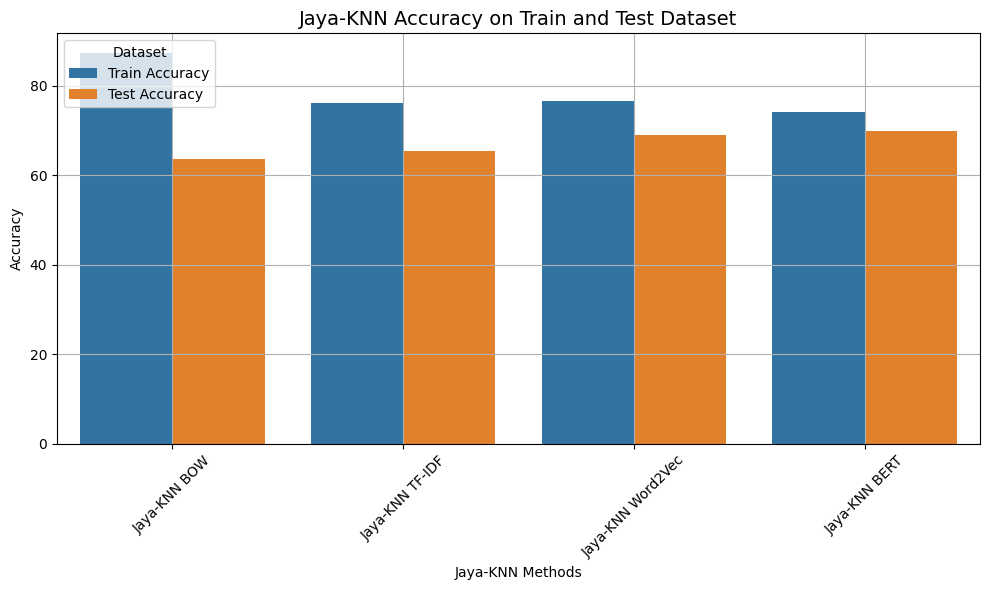

In [69]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
knn_accuracy_df_pivot = knn_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=knn_accuracy_df_pivot)
plt.xlabel('Jaya-KNN Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('Jaya-KNN Accuracy on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

-----

### `Jaya-Logisitc`

In [70]:
def logistic_with_jaya(method: str):
    ''' This Function is to train Logistic with Jaya optimizer. 
    Args:
    *****
        (method: str) --> The method one of (BOW, TFIDF, Word2Vec, BERT)
    '''
    
    ## Call the function --> split the dataset
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    def fitness_function(solution):
        ''' This is fitness function which will be passed to Jaya Optimizer & return accuracy score
        '''
        ## Choosing the params of Logistic
        c = solution[0]                 

        ## KNN Model
        log = LogisticRegression(C=c, random_state=45)
        ## Fit the model
        log.fit(X_train, y_train)

        ## Make the predictions
        y_pred = log.predict(X_test)

        ## Measure the performance (accuracy)
        return accuracy_score(y_test, y_pred)
    
    ## Use Jaya Optimizer, Prepare Bounds (Logistic Bounds for c)
    problem = {
        "fit_func": fitness_function,
        "lb": [0.01],
        "ub": [100],
        "minmax": "max",
                }
    
    ## Prepare bounds and the objective function
    model = LevyJA(epoch=15, pop_size=150)
    model.solve(problem)
    print(f"Best c: {model.solution[0][0]}")
    print('----'*15)
    
    ## Get the best params to train Logistic on it
    best_c = model.solution[0][0]

    ## Finally Logistic on tuned params
    log = LogisticRegression(C=best_c, random_state=45)
    log.fit(X_train, y_train)

    ## Accuracy
    y_pred_train = log.predict(X_train)
    y_pred_test = log.predict(X_test)

    acc_train = round(100*accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(100*accuracy_score(y_test, y_pred_test), 4)

    print(f'Accuracy Score for Training Dataset using {method} using Logistic: \t {acc_train} %')
    print(f'Accuracy Score for Tesing Dataset using {method} using Logistic: \t {acc_test} %')
    print('----'*15)

    ## I will return the Model itself (In case we want to download it or use it later for Deployment) with accuracies.
    return log, acc_train, acc_test

`1. Using BOW`

In [71]:
## Logistic using BOW Features
log_bow, acc_train_log_bow, acc_test_log_bow = logistic_with_jaya(method='BOW')

2023/09/02 07:18:23 PM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/02 07:18:54 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.7454545454545455, Global best: 0.7454545454545455, Runtime: 14.98005 seconds
2023/09/02 07:19:09 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.7454545454545455, Global best: 0.7454545454545455, Runtime: 14.91162 seconds
2023/09/02 07:19:22 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.7454545454545455, Global best: 0.7454545454545455, Runtime: 13.23618 seconds
2023/09/02 07:19:34 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.7454545454545455, Global best: 0.7454545454545455, Runtime: 12.36242 seconds
2023/09/02 07:19:46 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.7454545454545455, Global best: 0.7454545454545455, Runtime: 11.54928 seconds
2023/09/02 07

Best c: 7.656780926755967
------------------------------------------------------------
Accuracy Score for Training Dataset using BOW using Logistic: 	 97.0183 %
Accuracy Score for Tesing Dataset using BOW using Logistic: 	 74.5455 %
------------------------------------------------------------


`2. Using TFIDF`

In [72]:
## Logistic using TFIDF Features
log_tfidf, acc_train_log_tfidf, acc_test_log_tfidf = logistic_with_jaya(method='TFIDF')

2023/09/02 07:21:22 PM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/02 07:21:50 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.7545454545454545, Global best: 0.7545454545454545, Runtime: 13.12075 seconds
2023/09/02 07:22:03 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.7545454545454545, Global best: 0.7545454545454545, Runtime: 12.39340 seconds
2023/09/02 07:22:14 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.7545454545454545, Global best: 0.7545454545454545, Runtime: 11.18376 seconds
2023/09/02 07:22:25 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.7545454545454545, Global best: 0.7545454545454545, Runtime: 10.72329 seconds
2023/09/02 07:22:35 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.7545454545454545, Global best: 0.7545454545454545, Runtime: 10.28153 seconds
2023/09/02 07

Best c: 9.537378077290855
------------------------------------------------------------
Accuracy Score for Training Dataset using TFIDF using Logistic: 	 97.9358 %
Accuracy Score for Tesing Dataset using TFIDF using Logistic: 	 75.4545 %
------------------------------------------------------------


* `Combine all for Jaya-Logisitc` 

In [75]:
## Combine all results of Logistic with Jaya in one DataFrame
acc_train_log = [acc_train_log_bow, acc_train_log_tfidf]
acc_test_log = [acc_test_log_bow, acc_test_log_tfidf]


## Create a DataFrame for Logistic accuracies
data_log = {
        'Method': ['Jaya-Logistic BOW', 'Jaya-Logistic TF-IDF'],
        'Train Accuracy': acc_train_log,
        'Test Accuracy': acc_test_log
            }

log_accuracy_df = pd.DataFrame(data_log)
log_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,Jaya-Logistic BOW,87.3853,63.6364
1,Jaya-Logistic TF-IDF,76.1468,65.4545
2,Jaya-Logistic Word2Vec,76.6055,69.0909
3,Jaya-Logistic BERT,74.0826,70.0000


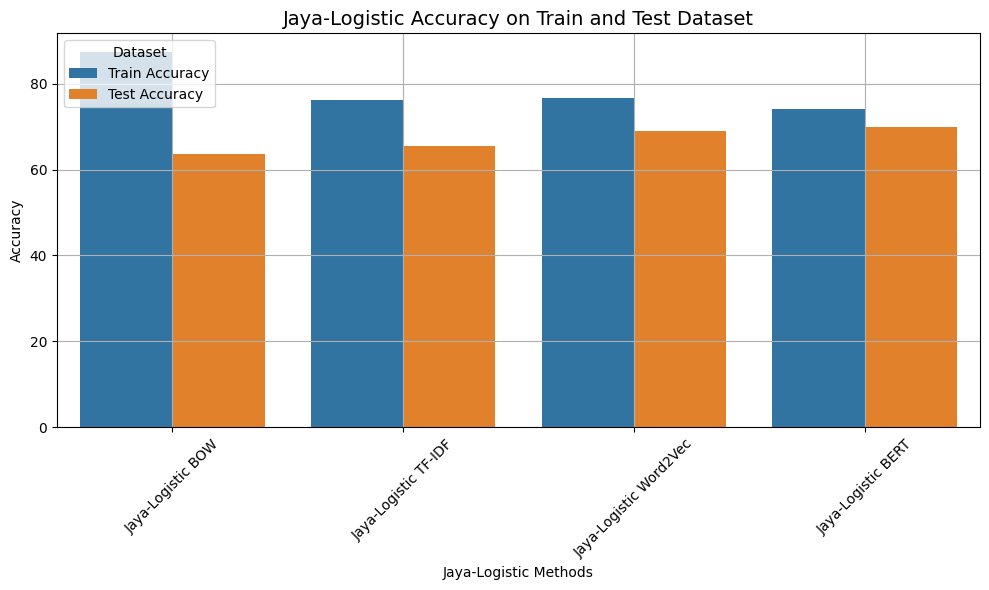

In [76]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
log_accuracy_df_pivot = log_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=log_accuracy_df_pivot)
plt.xlabel('Jaya-Logistic Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('Jaya-Logistic Accuracy on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

----

### `Jaya-RF`

In [77]:
def forest_with_jaya(method: str):
    ''' This Function is to train RF with Jaya optimizer. 
    Args:
    *****
        (method: str) --> The method one of (BOW, TFIDF, Word2Vec, BERT)
    '''
    
    ## Call the function --> split the dataset
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    def fitness_function(solution):
        ''' This is fitness function which will be passed to Jaya Optimizer & return accuracy score
        '''
        ## Choosing the params of RF
        n = int(solution[0])
        d = int(solution[1])

        ## RF Model
        forest = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=45)
        ## Fit the model
        forest.fit(X_train, y_train)

        ## Make the predictions
        y_pred = forest.predict(X_test)

        ## Measure the performance (accuracy)
        return accuracy_score(y_test, y_pred)
    
    ## Use Jaya Optimizer, Prepare Bounds for RF
    problem = {
        "fit_func": fitness_function,
        "lb": [30, 5],
        "ub": [500, 20]
        "minmax": "max",
                }
    
    ## Prepare bounds and the objective function
    model = LevyJA(epoch=15, pop_size=150)
    model.solve(problem)
    print(f"Best n_estimators: {int(model.solution[0][0])} \
            Best max_depth: {int(model.solution[0][1])}")
    
    print('----'*15)
    
    ## Get the best params to train RF on it
    best_n = int(model.solution[0][0])
    best_d = int(model.solution[0][1])

    ## Finally RF on tuned params
    forest = RandomForestClassifier(n_estimators=best_n, max_depth=best_d, random_state=45)
    forest.fit(X_train, y_train)

    ## Accuracy
    y_pred_train = forest.predict(X_train)
    y_pred_test = forest.predict(X_test)

    acc_train = round(100*accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(100*accuracy_score(y_test, y_pred_test), 4)

    print(f'Accuracy Score for Training Dataset using {method} using RF: \t {acc_train} %')
    print(f'Accuracy Score for Tesing Dataset using {method} using RF: \t {acc_test} %')
    print('----'*15)

    ## I will return the Model itself (In case we want to download it or use it later for Deployment) with accuracies.
    return forest, acc_train, acc_test

`1. Using BOW`

In [78]:
## RF using BOW Features
forest_bow, acc_train_forest_bow, acc_test_forest_bow = forest_with_jaya(method='BOW')

2023/09/02 07:34:50 PM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/02 07:36:47 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.6545454545454545, Global best: 0.6545454545454545, Runtime: 51.11775 seconds
2023/09/02 07:37:26 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.6545454545454545, Global best: 0.6545454545454545, Runtime: 39.18928 seconds
2023/09/02 07:38:00 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.6545454545454545, Global best: 0.6545454545454545, Runtime: 34.19306 seconds
2023/09/02 07:38:29 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.6636363636363637, Global best: 0.6636363636363637, Runtime: 28.68500 seconds
2023/09/02 07:38:56 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.6636363636363637, Global best: 0.6636363636363637, Runtime: 27.61117 seconds
2023/09/02 07

Best n_estimators: 32             Best max_depth: 17
------------------------------------------------------------
Accuracy Score for Training Dataset using BOW using RF: 	 83.7156 %
Accuracy Score for Tesing Dataset using BOW using RF: 	 67.2727 %
------------------------------------------------------------


`2. Using TFIDF`

In [79]:
## RF using TFIDF Features
forest_tfidf, acc_train_forest_tfidf, acc_test_forest_tfidf = forest_with_jaya(method='TFIDF')

2023/09/02 07:41:43 PM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/02 07:44:11 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.6636363636363637, Global best: 0.6636363636363637, Runtime: 78.43416 seconds
2023/09/02 07:45:33 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.6636363636363637, Global best: 0.6636363636363637, Runtime: 81.86572 seconds
2023/09/02 07:47:09 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.6727272727272727, Global best: 0.6727272727272727, Runtime: 95.74959 seconds
2023/09/02 07:48:54 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.6727272727272727, Global best: 0.6727272727272727, Runtime: 104.93859 seconds
2023/09/02 07:50:28 PM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.6727272727272727, Global best: 0.6727272727272727, Runtime: 94.44891 seconds
2023/09/02 0

Best n_estimators: 407             Best max_depth: 20
------------------------------------------------------------
Accuracy Score for Training Dataset using TFIDF using RF: 	 93.578 %
Accuracy Score for Tesing Dataset using TFIDF using RF: 	 67.2727 %
------------------------------------------------------------


* `Combine all for Jaya-RF` 

In [82]:
## Combine all results of RF Jaya in one DataFrame
acc_train_forest = [acc_train_forest_bow, acc_train_forest_tfidf]
acc_test_forest = [acc_test_forest_bow, acc_test_forest_tfidf]


## Create a DataFrame for RF accuracies
data_forest = {
        'Method': ['Jaya-RF BOW', 'Jaya-RF TF-IDF'],
        'Train Accuracy': acc_train_forest,
        'Test Accuracy': acc_test_forest
            }

forest_accuracy_df = pd.DataFrame(data_forest)
forest_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,Jaya-RF BOW,83.7156,67.2727
1,Jaya-RF TF-IDF,93.5780,67.2727
2,Jaya-RF Word2Vec,99.5413,78.1818
3,Jaya-RF BERT,100.0000,76.3636


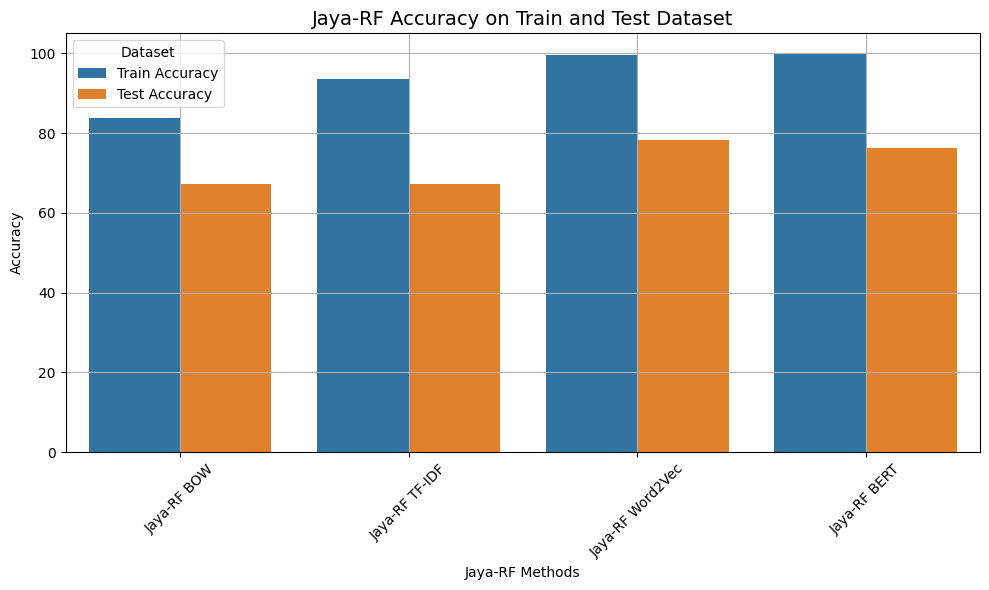

In [83]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
forest_accuracy_df_pivot = forest_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=forest_accuracy_df_pivot)
plt.xlabel('Jaya-RF Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('Jaya-RF Accuracy on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

----

### `Naive Bayes`
`No parameter need to be tuned in Naive Bayes, So It is just not right to use jaya with NB`

In [91]:
def naive_bayes_without_jaya(method: str): 
    ''' This Function is to train MODEL using the given method and returns the train and test accuracy.
    Args:
    ****
        (method: str) --> The method of features on of (BOW, TFIDF, Word2Vec, BERT)
    
    Returns:
    *******
        (acc_train_svc: float) --> The training accuracy 
        (acc_test_svc: float) --> The test accuracy
    ''' 
    
    ## Split the Dataset first --> Call the function
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## Naive Bayes without using jaya
    naive = GaussianNB()
    naive.fit(X_train, y_train)
    
    ## Accuracy
    y_pred_train = naive.predict(X_train)
    y_pred_test = naive.predict(X_test)
    
    acc_train = round(100*accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(100*accuracy_score(y_test, y_pred_test), 4)
    
    ## I will return the Model itself (In case we want to download it or use it later for Deployment) with accuracies.
    return naive, acc_train, acc_test

`1. Using BOW`

In [92]:
## BOW using naive bayes
naive_bow, acc_train_naive_bow, acc_test_naive_bow = naive_bayes_without_jaya(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using NaiveBayes without Jaya \t {acc_train_naive_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using NaiveBayes without Jaya \t {acc_test_naive_bow} %')

Accuracy Score for Training Dataset using BOW using NaiveBayes without Jaya 	 89.6789 %
Accuracy Score for Testing Dataset using BOW using NaiveBayes without Jaya 	 70.9091 %


`2. Using TFIDF`

In [93]:
## TFIDF using naive bayes
naive_tfidf, acc_train_naive_tfidf, acc_test_naive_tfidf = naive_bayes_without_jaya(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using NaiveBayes without Jaya \t {acc_train_naive_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using NaiveBayes without Jaya \t {acc_test_naive_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using NaiveBayes without Jaya 	 92.4312 %
Accuracy Score for Testing Dataset using TFIDF using NaiveBayes without Jaya 	 70.9091 %


* `Combine all results for NB without Jaya`

In [96]:
## Combine all results of Naive wihtout Jaya in one DataFrame
acc_train_naive = [acc_train_naive_bow, acc_train_naive_tfidf]
acc_test_naive = [acc_test_naive_bow, acc_test_naive_tfidf]


## Create a DataFrame for SVM accuracies
data_naive = {
        'Method': ['NB BOW', 'NB TF-IDF'],
        'Train Accuracy': acc_train_naive,
        'Test Accuracy': acc_test_naive
            }

naive_accuracy_df = pd.DataFrame(data_naive)
naive_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,NB BOW,89.6789,70.9091
1,NB TF-IDF,92.4312,70.9091
2,NB Word2Vec,72.4771,64.5455
3,NB BERT,71.1009,60.9091


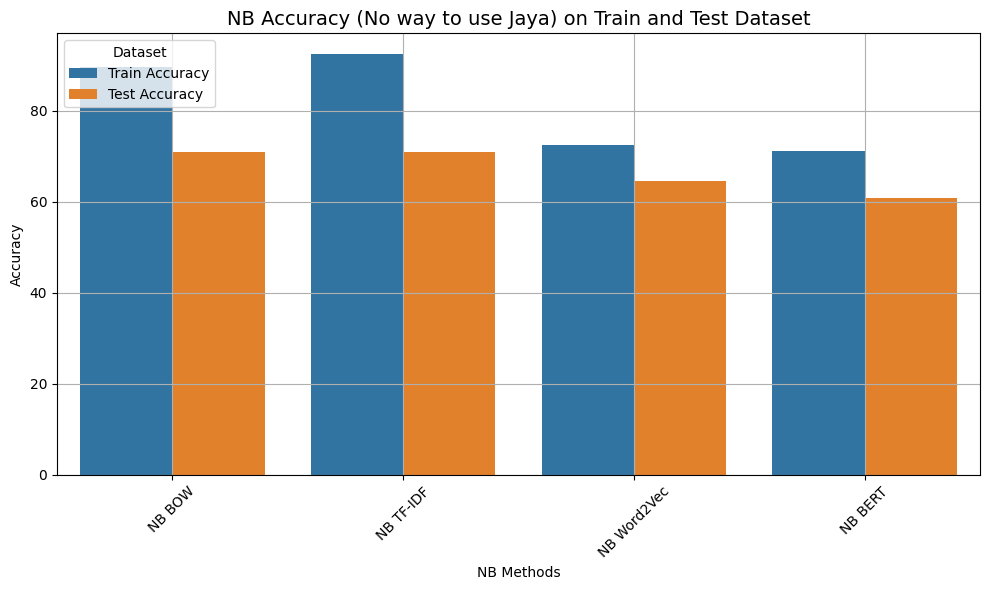

In [97]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
naive_accuracy_df_pivot = naive_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=naive_accuracy_df_pivot)
plt.xlabel('NB Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('NB Accuracy (No way to use Jaya) on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

----

### `Jaya-GBoost`

In [98]:
def gboost_with_jaya(method: str):
    ''' This Function is to train XGBoost with Jaya optimizer. 
    Args:
    *****
        (method: str) --> The method one of (BOW, TFIDF, Word2Vec, BERT)
    '''
    
    ## Call the function --> split the dataset
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    def fitness_function(solution):
        ''' This is fitness function which will be passed to Jaya Optimizer & return accuracy score
        '''
        ## Choosing the params of Gboost
        n = int(solution[0])
        d = int(solution[1])

        ## Gboost Model
        gboost = XGBClassifier(n_estimators=n, max_depth=d, learning_rate=0.1, random_state=45)
        ## Fit the model
        gboost.fit(X_train, y_train)

        ## Make the predictions
        y_pred = gboost.predict(X_test)

        ## Measure the performance (accuracy)
        return accuracy_score(y_test, y_pred)
    
    ## Use Jaya Optimizer, Prepare Bounds for Gboost
    problem = {
        "fit_func": fitness_function,
        "lb": [100, 2],
        "ub": [400, 10],
        "minmax": "max",
                }
    
    ## Prepare bounds and the objective function
    model = LevyJA(epoch=15, pop_size=150)
    model.solve(problem)
    print(f"Best n_estimators: {int(model.solution[0][0])} \
            Best max_depth: {int(model.solution[0][1])}")
    print('----'*15)
    
    ## Get the best params to train DT on it
    best_n = int(model.solution[0][0])
    best_d = int(model.solution[0][1])

    ## Finally GBoost on tuned params
    gboost = XGBClassifier(n_estimators=best_n, max_depth=best_d, learning_rate=0.1, random_state=45)
    gboost.fit(X_train, y_train)

    ## Accuracy
    y_pred_train = gboost.predict(X_train)
    y_pred_test = gboost.predict(X_test)

    acc_train = round(100*accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(100*accuracy_score(y_test, y_pred_test), 4)

    print(f'Accuracy Score for Training Dataset using {method} using GBoost: \t {acc_train} %')
    print(f'Accuracy Score for Tesing Dataset using {method} using GBoost: \t {acc_test} %')
    print('----'*15)

    ## I will return the Model itself (In case we want to download it or use it later for Deployment) with accuracies.
    return gboost, acc_train, acc_test

`1. Using BOW`

In [99]:
## BOW using gboost
gboost_bow, acc_train_gboost_bow, acc_test_gboost_bow = gboost_with_jaya(method='BOW')

2023/09/03 12:05:30 AM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/03 12:13:34 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.7090909090909091, Global best: 0.7090909090909091, Runtime: 270.40797 seconds
2023/09/03 12:18:25 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.7090909090909091, Global best: 0.7090909090909091, Runtime: 290.89545 seconds
2023/09/03 12:23:41 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.7090909090909091, Global best: 0.7090909090909091, Runtime: 316.13009 seconds
2023/09/03 12:29:10 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.7090909090909091, Global best: 0.7090909090909091, Runtime: 328.31242 seconds
2023/09/03 12:35:13 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.7090909090909091, Global best: 0.7090909090909091, Runtime: 363.29710 seconds
2023/09/

Best n_estimators: 351             Best max_depth: 8
------------------------------------------------------------
Accuracy Score for Training Dataset using BOW using GBoost: 	 87.844 %
Accuracy Score for Tesing Dataset using BOW using GBoost: 	 70.9091 %
------------------------------------------------------------


`2. Using TFIDF`

In [100]:
## TFIDF using gboost
gboost_tfidfi, acc_train_gboost_tfidfi, acc_test_gboost_tfidfi = gboost_with_jaya(method='TFIDF')

2023/09/03 01:29:51 AM, INFO, mealpy.swarm_based.JA.LevyJA: Solving single objective optimization problem.
2023/09/03 01:35:36 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 1, Current best: 0.7, Global best: 0.7, Runtime: 161.12290 seconds
2023/09/03 01:38:07 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 2, Current best: 0.7, Global best: 0.7, Runtime: 150.72570 seconds
2023/09/03 01:40:22 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 3, Current best: 0.7, Global best: 0.7, Runtime: 135.46757 seconds
2023/09/03 01:42:35 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 4, Current best: 0.7, Global best: 0.7, Runtime: 133.26489 seconds
2023/09/03 01:44:42 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 5, Current best: 0.7, Global best: 0.7, Runtime: 126.31565 seconds
2023/09/03 01:46:44 AM, INFO, mealpy.swarm_based.JA.LevyJA: >Problem: P, Epoch: 6, Current best: 0.7, Global best: 0.7, Runtime: 122.44454 seconds
2023/09/03 

Best n_estimators: 328             Best max_depth: 3
------------------------------------------------------------
Accuracy Score for Training Dataset using TFIDF using GBoost: 	 91.055 %
Accuracy Score for Tesing Dataset using TFIDF using GBoost: 	 70.0 %
------------------------------------------------------------


* `Combine all for Jaya-GBoost` 

In [104]:
## Combine all results of GBOOST Jaya in one DataFrame
acc_train_gboost = [acc_train_gboost_bow, acc_train_gboost_tfidfi]
acc_test_gboost = [acc_test_gboost_bow, acc_test_gboost_tfidfi]


## Create a DataFrame for GBOOST accuracies
data_gboost = {
        'Method': ['Jaya-GBoost BOW', 'Jaya-GBoost TF-IDF'],
        'Train Accuracy': acc_train_gboost,
        'Test Accuracy': acc_test_gboost
            }

gboost_accuracy_df = pd.DataFrame(data_gboost)
gboost_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,Jaya-GBoost BOW,87.8440,70.9091
1,Jaya-GBoost TF-IDF,91.0550,70.0000
2,Jaya-GBoost Word2Vec,99.5413,76.3636
3,Jaya-GBoost BERT,100.0000,71.8182


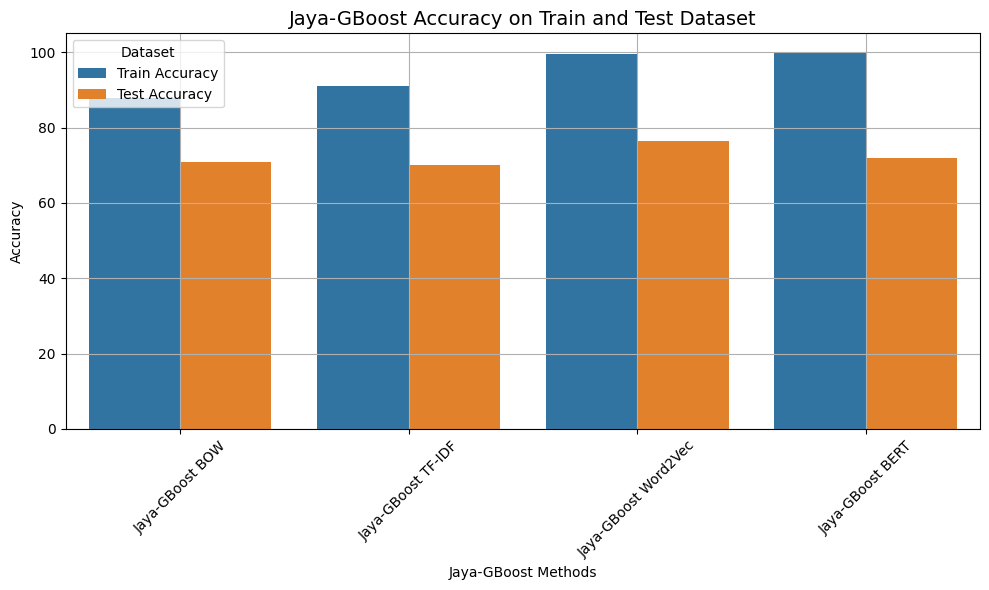

In [105]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
gboost_accuracy_df_pivot = gboost_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=gboost_accuracy_df_pivot)
plt.xlabel('Jaya-GBoost Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('Jaya-GBoost Accuracy on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

----

## <center> Done </center>

--------------